In [209]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import OLSInfluence
import pyreadr

# Problem 1
a. Obtain the studentized deleted residuals and identify any outlying Y observations. Use the Bonferroni outlier test procedure with α = .10. State the decision rule and conclusion.


In [210]:
df = pd.read_csv('CH06PR15_PatientSatisfaction.txt', sep='\s+', names=['y', 'x1', 'x2', 'x3'])
#df.drop(columns=['Unnamed: 0'], inplace=True)
df.head()

,y,x1,x2,x3
0,48,50,51,2.3
1,57,36,46,2.3
2,66,40,48,2.2
3,70,41,44,1.8
4,89,28,43,1.8


In [211]:
X = df[['x1', 'x2', 'x3']]
Y = df['y']
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.659
Method:                 Least Squares   F-statistic:                     30.05
Date:                Sun, 27 Apr 2025   Prob (F-statistic):           1.54e-10
Time:                        22:42:40   Log-Likelihood:                -169.36
No. Observations:                  46   AIC:                             346.7
Df Residuals:                      42   BIC:                             354.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        158.4913     18.126      8.744      0.0

In [212]:
n = 46
p = 4
alpha_star = 0.1/n
t_val = stats.t.ppf(q = 1 - alpha_star/2, df=n - 4 - 1)
print(f"t-value for Bonferroni correction: {t_val:.4f}")

t-value for Bonferroni correction: 3.2715


In [213]:
test_class = OLSInfluence(model)
np.abs(test_class.resid_studentized_external)

0     0.011555
1     0.933179
2     0.403625
3     0.214666
4     0.594417
5     0.381671
6     1.306938
7     0.043505
8     0.729007
9     0.202832
10    1.835846
11    1.362219
12    1.498367
13    1.558052
14    1.357623
15    0.281510
16    1.806742
17    0.874528
18    1.102377
19    0.867553
20    0.573154
21    0.901148
22    0.368162
23    0.409310
24    0.476760
25    0.432335
26    1.974202
27    0.589891
28    0.988725
29    0.347340
30    1.769416
31    1.219938
32    0.061648
33    1.542156
34    0.095941
35    1.176307
36    1.227789
37    0.549421
38    0.986985
39    0.589772
40    1.118953
41    0.095402
42    1.422228
43    1.345415
44    0.567127
45    1.044921
dtype: float64

In [214]:
count = 0
for _ in test_class.resid_studentized_external:
    if _ > t_val or _ < -t_val:
        count += 1
print(f"Number of outliers: {count}")

Number of outliers: 0


If studentized deleted residuals |ti| > t (1-alpha_star/2; n-p-1) with alpha_star = alpha/n, then the i-th observation is a Bonferroni outlier.  
In this case, there is no studentized deleted residuals greater than absolute value of critical value t, so there are no outliers.  
b. Obtain the diagonal elements of the hat matrix. Identify any outlying X observations.   


In [215]:
print(test_class.hat_matrix_diag)

[0.07819669 0.06706793 0.03717097 0.15361084 0.09673692 0.12857668
 0.034485   0.07524431 0.18425851 0.0579791  0.08759237 0.03087466
 0.09032064 0.0332376  0.14289032 0.04713297 0.11954226 0.06241738
 0.03350767 0.12892851 0.07769553 0.13690056 0.0328805  0.13575135
 0.04336732 0.1029463  0.08682305 0.18601919 0.0594421  0.08998056
 0.11710546 0.10963099 0.04504471 0.03717097 0.10303977 0.0272323
 0.12122091 0.07058923 0.1809601  0.08689598 0.03797572 0.15385909
 0.06101915 0.05090958 0.07261644 0.08315177]


Given 2p/n = 2*4/46 = 0.17391304347826086  
Starting from 0, the 9th, 18th, 39th observations may be the outliers in X  
c. Hospital management wishes to estimate mean patient satisfaction for patients who are X1 = 30 years old, whose index of illness severity is X2 = 58, and whose index of anxiety level is X3 = 2.0. Use (10.29) to determine whether this estimate will involve a hidden extrapolation.

In [216]:
import numpy.linalg as linalg

XtX = X.T.dot(X)
inv_XtX = linalg.inv(XtX)
inv_XtXXt = inv_XtX.dot(X.T)
beta_hat = inv_XtXXt.dot(Y)
hat_matrix = X.dot(inv_XtX.dot(X.T))
b = np.matmul(inv_XtXXt, Y)
J = np.ones((len(Y), len(Y)))
SSR = b.T.dot(X.T.dot(Y)) - (1/len(Y))*Y.T.dot(J.dot(Y))
MSE = SSR/2

In [217]:
X_hat = np.array([1, 30, 58, 2])
h_x0 = X_hat.T.dot(inv_XtX).dot(X_hat)
print(f"Hat value for new observation: {h_x0:.4f}")

Hat value for new observation: 0.3267


In [218]:
b0 = model.params[0]
b1 = model.params[1]
b2 = model.params[2]
b3 = model.params[3]

y_hat = b0 + b1*30 + b2*58 + b3*2


var_y_hat = MSE*(1+X_hat.T.dot(inv_XtX).dot(X_hat))

t_val = stats.t.ppf(q = 1 - 0.1/2, df=n - 4)

U = y_hat + t_val*np.sqrt(var_y_hat)
L = y_hat - t_val*np.sqrt(var_y_hat)
print(var_y_hat)
print(f"Predicted range of new observation: ({L:.4f}, {U:.4f})")

6050.061555502141
Predicted range of new observation: (-59.1595, 202.4922)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_23288\548698478.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  b0 = model.params[0]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_23288\548698478.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  b1 = model.params[1]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_23288\548698478.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  b2 = model.params[2]
C:\Users\ASUS\AppData\Local\Temp\ipykern

The hat value for new observation is 0.3267 > 2p/n = 0.1739 suggesting this may involve a hidden extrapolation  
d. The three largest absolute studentized deleted residuals are for cases 11, 17, and 27. Obtain the DFFITS, DFBETAS, and Cook’s distance values for this case to assess its influence. What do you conclude?


In [219]:
h11 = 0.08759237
h17 = 0.11954226
h27 = 0.08682305

In [220]:
test_class.dffits

(0     0.003365
 1    -0.250206
 2     0.079306
 3     0.091451
 4     0.194527
 5    -0.146607
 6    -0.246996
 7     0.012410
 8    -0.346473
 9     0.050320
 10    0.568820
 11    0.243141
 12   -0.472136
 13   -0.288893
 14    0.554323
 15   -0.062609
 16    0.665737
 17    0.225643
 18   -0.205259
 19    0.333767
 20    0.166354
 21    0.358896
 22    0.067884
 23   -0.162220
 24   -0.101510
 25   -0.146459
 26   -0.608740
 27    0.281997
 28   -0.248559
 29    0.109220
 30   -0.644413
 31    0.428074
 32    0.013389
 33   -0.303009
 34    0.032518
 35    0.196815
 36    0.456008
 37   -0.151416
 38   -0.463927
 39   -0.181938
 40    0.222317
 41   -0.040681
 42   -0.362555
 43    0.311603
 44   -0.158697
 45    0.314681
 dtype: float64,
 0.5897678246195885)

In [221]:

dffits11 = test_class.resid_studentized_external[10]*np.sqrt(h11/(1-h11))
dffits17 = test_class.resid_studentized_external[16]*np.sqrt(h17/(1-h17))
dffits27 = test_class.resid_studentized_external[26]*np.sqrt(h27/(1-h27))
print(dffits11, dffits17, dffits27)
print(2* np.sqrt(p/n))


0.5688199854266384 0.6657369834775247 -0.6087397403331006
0.5897678246195885


--> dffits for case 17 and 27 may be influential to their own predicted value

In [222]:
# Cook distance
test_class.cooks_distance

(0     0.000003
 1     0.015699
 2     0.001604
 3     0.002139
 4     0.009608
 5     0.005485
 6     0.014999
 7     0.000039
 8     0.030349
 9     0.000648
 10    0.076568
 11    0.014484
 12    0.054124
 13    0.020179
 14    0.075307
 15    0.001002
 16    0.105133
 17    0.012800
 18    0.010479
 19    0.028015
 20    0.007031
 21    0.032346
 22    0.001176
 23    0.006712
 24    0.002624
 25    0.005468
 26    0.086662
 27    0.020194
 28    0.015454
 29    0.003046
 30    0.098804
 31    0.045285
 32    0.000046
 33    0.022224
 34    0.000271
 35    0.009596
 36    0.051365
 37    0.005829
 38    0.053840
 39    0.008406
 40    0.012282
 41    0.000424
 42    0.032080
 43    0.023815
 44    0.006400
 45    0.024702
 dtype: float64,
 array([1.        , 0.99949529, 0.99999462, 0.99999044, 0.99980927,
        0.99993747, 0.99953883, 1.        , 0.99815345, 0.99999912,
        0.98900393, 0.99956961, 0.99432562, 0.99917155, 0.98934397,
        0.9999979 , 0.98009665, 0.99966304,

In [223]:
cook11 = ((df['y'][10] - (b0 + b1*df['x1'][10] + b2*df['x2'][10] + b3*df['x3'][10]))**2) * h11 / ((p * MSE) * (1 - h11)**2)
cook17 = ((df['y'][16] - (b0 + b1*df['x1'][16] + b2*df['x2'][16] + b3*df['x3'][16]))**2) * h17 / ((p * MSE) * (1 - h17)**2)
cook27 = ((df['y'][26] - (b0 + b1*df['x1'][26] + b2*df['x2'][26] + b3*df['x3'][26]))**2) * h27 / ((p * MSE) * (1 - h27)**2) 
print(cook11, cook17, cook27)

0.0016985587568698252 0.0023322501453876894 0.0019224937471986757


In [224]:
print(test_class.cooks_distance[0][10] > 1)
print(test_class.cooks_distance[0][16] > 1)
print(test_class.cooks_distance[0][26] > 1)

False
False
False


--> cooks distance suggests of not being influential to thhe regression model

In [225]:
# DFBETAS
test_class.dfbetas

array([[ 0.00059776,  0.00284789, -0.00063411, -0.00098264],
       [-0.16086897, -0.01182832,  0.19908791, -0.13165429],
       [ 0.04743579,  0.03688168, -0.040347  , -0.00449104],
       [ 0.06676902,  0.06020385, -0.03626538, -0.04655348],
       [ 0.16094283, -0.00293656, -0.07483972, -0.05538875],
       [ 0.03718058, -0.01616584,  0.04770617, -0.11170514],
       [-0.06672179, -0.13638214,  0.01767293,  0.09883387],
       [ 0.00603661,  0.00691179, -0.00918685,  0.00439879],
       [ 0.30441165,  0.01270385, -0.20589029, -0.04252055],
       [-0.00263725, -0.0320284 ,  0.0224854 , -0.01233609],
       [ 0.09910764, -0.36308922, -0.18998869,  0.38998516],
       [-0.09031929,  0.04909034,  0.07544702, -0.02076468],
       [ 0.24943512,  0.0902979 , -0.40426632,  0.27230826],
       [ 0.05102285,  0.16647995, -0.08164952, -0.03807876],
       [-0.06500609,  0.40734624,  0.16235741, -0.36267745],
       [-0.01863756, -0.00951146, -0.01421625,  0.04347811],
       [-0.44913479, -0.

In [226]:
print(2/np.sqrt(n))
print(test_class.dfbetas[10][1] > 2/np.sqrt(n))
print(test_class.dfbetas[16][1] > 2/np.sqrt(n))
print(test_class.dfbetas[26][1] > 2/np.sqrt(n))

0.29488391230979427
False
False
True


dfbetas for case 27 may be influential to their own coefficient  
e. Calculate the average absolute percent difference in the fitted values with and without each of these cases. What does this measure indicate about the influence of each of these cases?

In [227]:
df11 = df.copy().drop(index=10)
df17 = df.copy().drop(index=16)
df27 = df.copy().drop(index=26)

X11 = sm.add_constant(df11[['x1', 'x2', 'x3']])
X17 = sm.add_constant(df17[['x1', 'x2', 'x3']])
X27 = sm.add_constant(df27[['x1', 'x2', 'x3']])

model11 = sm.OLS(df11['y'], X11).fit()
model17 = sm.OLS(df17['y'], X17).fit()
model27 = sm.OLS(df27['y'], X27).fit()


In [228]:
X_obs = np.array([1, 30, 58, 2]) 
pred_full = model.predict(X_obs)

In [229]:
pred11 = model11.predict(X_obs)
pred17 = model17.predict(X_obs)
pred27 = model27.predict(X_obs)

APD11 = np.abs((pred11 - pred_full) / pred_full) * 100
APD17 = np.abs((pred17 - pred_full) / pred_full) * 100
APD27 = np.abs((pred27 - pred_full) / pred_full) * 100


AAPD = (APD11 + APD17 + APD27) / 3

print(APD11, APD17, APD27)
print(AAPD)

[0.57959559] [3.72137404] [3.32314315]
[2.54137093]


All cases have small percentage so they are little influential

f. Calculate Cook’s distance Di for each case and prepare an index plot. Are any cases influential according to this measure?

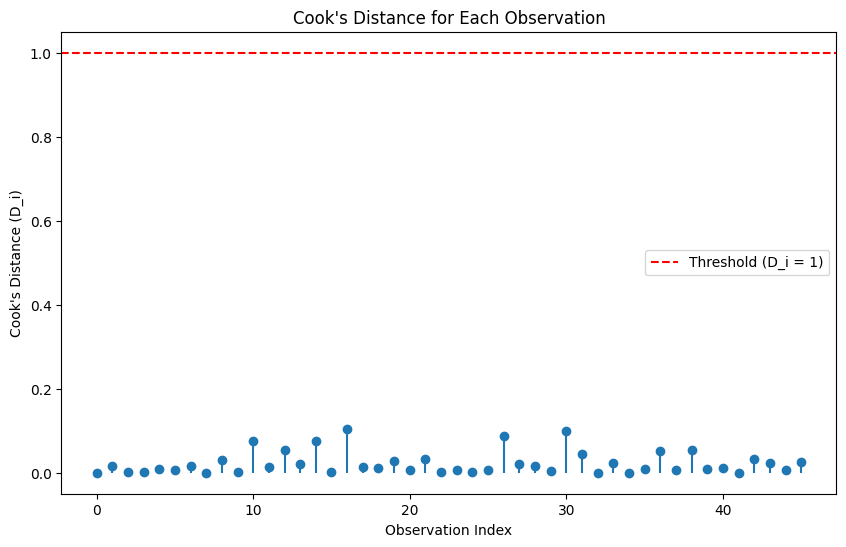

Influential cases (D_i > 1): []


In [230]:
cooks_d = test_class.cooks_distance[0]

plt.figure(figsize=(10, 6))
plt.stem(range(len(cooks_d)), cooks_d, basefmt=" ")
plt.axhline(y=1, color='r', linestyle='--', label="Threshold (D_i = 1)")
plt.title("Cook's Distance for Each Observation")
plt.xlabel("Observation Index")
plt.ylabel("Cook's Distance (D_i)")
plt.legend()
plt.show()

influential_cases = [i for i, d in enumerate(cooks_d) if d > 1]
print(f"Influential cases (D_i > 1): {influential_cases}")

# Problem 2

In [231]:
result = pyreadr.read_r('cement.rda')
df = next(iter(result.values()))
df

,y,x1,x2,x3,x4
rownames,,,,,
1,78.5,7.0,26.0,6.0,60.0
2,74.3,1.0,29.0,15.0,52.0
3,104.3,11.0,56.0,8.0,20.0
4,87.6,11.0,31.0,8.0,47.0
5,95.9,7.0,52.0,6.0,33.0
6,109.2,11.0,55.0,9.0,22.0
7,102.7,3.0,71.0,17.0,6.0
8,72.5,1.0,31.0,22.0,44.0
9,93.1,2.0,54.0,18.0,22.0


In [232]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[['x1', 'x2', 'x3', 'x4']])
df_scaled = pd.DataFrame(df_scaled, columns=['x1', 'x2', 'x3', 'x4'])
df_scaled['y'] = df['y'].values
df_scaled

,x1,x2,x3,x4,y
0,-0.081665,-1.481822,-0.9375,1.865495,78.5
1,-1.143307,-1.281158,0.5250,1.368030,74.3
2,0.626097,0.524812,-0.6125,-0.621832,104.3
3,0.626097,-1.147383,-0.6125,1.057114,87.6
4,-0.081665,0.257261,-0.9375,0.186549,95.9
5,0.626097,0.457924,-0.4500,-0.497465,109.2
6,-0.789426,1.528129,0.8500,-1.492396,102.7
7,-1.143307,-1.147383,1.6625,0.870564,72.5
8,-0.966367,0.391036,1.0125,-0.497465,93.1
9,2.395500,-0.077178,-1.2625,-0.248733,115.9


a. From the matrix of correlations between the regressors, would you suspect that multicollinearity is present?

Text(0.5, 1.0, 'Correlation Matrix Heatmap')

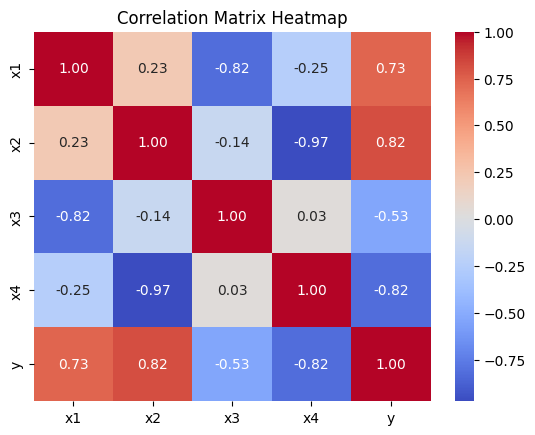

In [233]:
#matrix of correlation
corr_matrix = df_scaled.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix Heatmap")

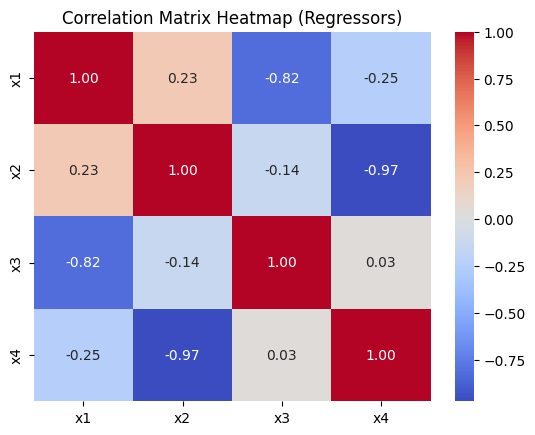

In [234]:
#matrix of correlation between regressors
corr_matrix_regressors = df_scaled[['x1', 'x2', 'x3', 'x4']].corr()
sns.heatmap(corr_matrix_regressors, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix Heatmap (Regressors)")
plt.show()

High correlation between x1 & x3, x2 & x4 suggest potential multicolinearity  
b. Calculate the variance inflation factors.

In [235]:
#variance inflation factors
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(df_scaled[['x1', 'x2', 'x3', 'x4']].values, i) for i in range(df_scaled[['x1', 'x2', 'x3', 'x4']].shape[1])]
vif['Feature'] = df_scaled[['x1', 'x2', 'x3', 'x4']].columns
print(vif)

          VIF Feature
0   38.496211      x1
1  254.423166      x2
2   46.868386      x3
3  282.512865      x4


All predictors have extremely high VIFs --> high multicolinearity  
c. Find the eigenvalues of X′X.

In [236]:
#eigenvalues of X′X
import numpy.linalg as linalg

X = df_scaled[['x1', 'x2', 'x3', 'x4']].values
X = sm.add_constant(X)
Y = df_scaled['y'].values
eigenvalues = linalg.eigvals(X.T.dot(X))
print("Eigenvalues of X'X:", eigenvalues)

Eigenvalues of X'X: [1.30000000e+01 2.90641525e+01 2.04888589e+01 2.42587994e+00
 2.11086945e-02]


The first 3 eigenvalues are big, however the 4th is acceptable small while the last one 0.0211, which is around 0 suggest that there is serious multicollinearity along at least one linear combination of our predictors  
d. Find the condition number of X′X

In [237]:
condition_number = np.sqrt(eigenvalues.max() / eigenvalues.min())
print("Condition number:", condition_number)

Condition number: 37.10634206384642


Condition number in the range 30-100 indicating a moderate to strong multicolinearity  
# Problem 3  
a. Use the ridge trace to select an appropriate value of k. Is the final model a good one?

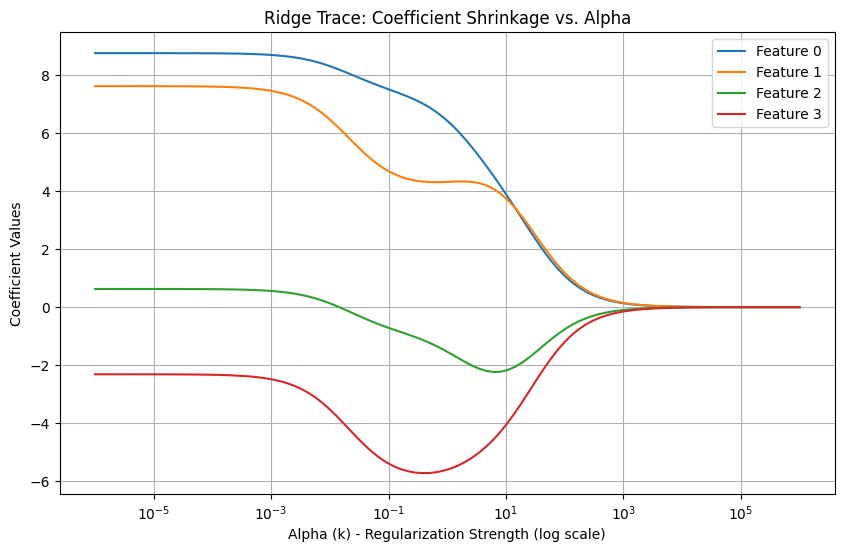

In [238]:
#Ridge regression
from sklearn.linear_model import Ridge
alphas = np.logspace(-6, 6, 100)

coefs = []
for alpha in alphas:
    ridge = Ridge(alpha=alpha, fit_intercept=True)
    ridge.fit(df_scaled[['x1', 'x2', 'x3', 'x4']], df_scaled[['y']])
    coefs.append(ridge.coef_)

# Plot Ridge Trace
plt.figure(figsize=(10, 6))
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')  # Log scale for alpha
plt.xlabel('Alpha (k) - Regularization Strength (log scale)')
plt.ylabel('Coefficient Values')
plt.title('Ridge Trace: Coefficient Shrinkage vs. Alpha')
plt.legend([f'Feature {i}' for i in range(X.shape[1])])
plt.grid(True)
plt.show()


In [239]:
from sklearn.linear_model import RidgeCV

# Automatically find best alpha via CV
ridge_cv = RidgeCV(alphas=alphas, cv=5)  # 5-fold CV
ridge_cv.fit(df_scaled[['x1', 'x2', 'x3', 'x4']], df_scaled[['y']])
best_alpha = ridge_cv.alpha_
print(f"Best alpha (k): {best_alpha}")

Best alpha (k): 0.6579332246575682


In [240]:
from sklearn.metrics import mean_squared_error, r2_score

# Predict with best alpha
y_pred = ridge_cv.predict(df_scaled[['x1', 'x2', 'x3', 'x4']])

# Metrics
mse = mean_squared_error(df_scaled[['y']], y_pred)
r2 = r2_score(df_scaled[['y']], y_pred)
print(f"MSE: {mse:.4f}, R²: {r2:.4f}")

MSE: 3.9912, R²: 0.9809


R quare close to 1 --> good fit

In [241]:
from sklearn.model_selection import cross_val_score

# Standardized data (X_scaled, y from previous example)
ridge = Ridge(alpha=best_alpha)  # Use your chosen alpha

# Perform 5-fold cross-validation on R² score
cv_scores = cross_val_score(ridge, df_scaled[['x1', 'x2', 'x3', 'x4']], df_scaled[['y']], cv=5, scoring='r2')

print("Cross-Validation R² Scores:", cv_scores)
print("Mean R²:", cv_scores.mean())
print("Standard Deviation:", cv_scores.std())

# Interpretation:
if cv_scores.std() < 0.1:
    print("✅ Model generalizes well (low variance across folds).")
else:
    print("⚠️ High variance in performance; check for overfitting.")

Cross-Validation R² Scores: [0.98742016 0.89661077 0.93052101 0.94400323 0.12039755]
Mean R²: 0.775790543513334
Standard Deviation: 0.3289868141654965
⚠️ High variance in performance; check for overfitting.


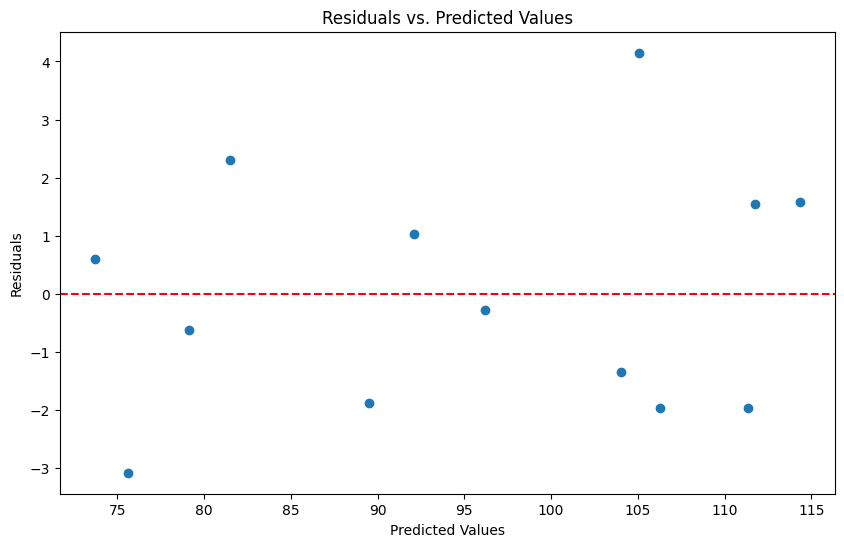

In [242]:
# residuals plot
residuals = df_scaled['y'] - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs. Predicted Values")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

The data points line randomly, indicating a good model and having a constant variance

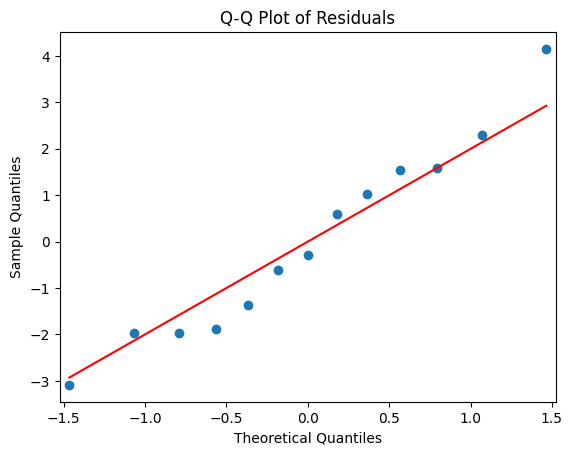

In [243]:
# Q-Q plot
sm.qqplot(residuals, line='s')
plt.title("Q-Q Plot of Residuals")
plt.show()

QQ-Plot straight line --> Residuals are normally distributed.  
b. How much inflation in the residual sum of squares has resulted from the use of ridge regression?

In [244]:
# Fit OLS 
model = sm.OLS(Y,X).fit()
y_pred_ols = model.predict(X)
rss_ols = np.sum((Y - y_pred_ols) ** 2)

# Fit Ridge Regression (use your chosen alpha)
ridge = Ridge(alpha=best_alpha) 
ridge.fit(X, Y)
y_pred_ridge = ridge.predict(X)
rss_ridge = np.sum((Y - y_pred_ridge) ** 2)

# Compute RSS inflation
rss_inflation = rss_ridge - rss_ols
inflation_percentage = (rss_inflation / rss_ols) * 100

print(f"OLS RSS: {rss_ols:.4f}")
print(f"Ridge RSS: {rss_ridge:.4f}")
print(f"RSS Inflation: {rss_inflation:.4f} ({inflation_percentage:.2f}%)")

OLS RSS: 47.8636
Ridge RSS: 51.8859
RSS Inflation: 4.0223 (8.40%)


Higher RSS in Ridge (8.40% increase) suggests that the regularization might be helping to improve generalization and reduce overfitting, even if the fit is slightly worse on training data.

In [245]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

# Cross-validated R² for OLS
ols_scores = cross_val_score(LinearRegression(), X, Y, cv=5, scoring='r2')
print(f"OLS R² (CV): {ols_scores.mean():.3f} ± {ols_scores.std():.3f}")

# Cross-validated R² for Ridge
ridge_scores = cross_val_score(Ridge(alpha=best_alpha), X, Y, cv=5, scoring='r2')
print(f"Ridge R² (CV): {ridge_scores.mean():.3f} ± {ridge_scores.std():.3f}")

OLS R² (CV): 0.671 ± 0.528
Ridge R² (CV): 0.776 ± 0.329


Higher CV --> evidence ridge help prevent overfitting  
c. Compare the ridge regression model with the two-regressor model involving x1 and x2 developed by all possible regressions in Example 9.1.

In [246]:
# Metrics
rss_ridge = ((Y - y_pred_ridge) ** 2).sum()
r2_ridge = ridge.score(X, Y)

#OLS 2 regressors
X_2 = df[['x1', 'x2']]
X_2 = sm.add_constant(X_2)
model_2 = sm.OLS(Y, X_2).fit()
y_pred_2 = model_2.predict(X_2)
rss_2 = np.sum((Y - y_pred_2) ** 2).sum()
r2_ols_2 = model_2.rsquared

print(f"Ridge RSS: {rss_ridge:.4f}, R²: {r2_ridge:.4f}")
print(f"OLS RSS (2 regressors): {rss_2:.4f}, R²: {r2_ols_2:.4f}")

Ridge RSS: 51.8859, R²: 0.9809
OLS RSS (2 regressors): 57.9045, R²: 0.9787


In [247]:
ridge_cv_r2 = cross_val_score(Ridge(alpha=best_alpha), X, Y, cv=5, scoring='r2').mean()
ols_cv_r2 = cross_val_score(LinearRegression(), X_2, Y, cv=5, scoring='r2').mean()

print(f"Ridge R² (CV): {ridge_cv_r2:.3f}")
print(f"OLS R² (CV): {ols_cv_r2:.3f}")

Ridge R² (CV): 0.776
OLS R² (CV): 0.616


In [248]:
print("Ridge coefs:", ridge.coef_)
print("OLS (x1, x2) coefs:\n", model_2.params)

Ridge coefs: [ 0.          6.72751549  4.31330636 -1.34655749 -5.69488462]
OLS (x1, x2) coefs:
 const    52.577349
x1        1.468306
x2        0.662250
dtype: float64


The 2 models are quite identical, however, ridge perform a little better as RSS is smaller and R square is larger suggesting a minimal improvement.  
Considering the cross validation and coefs reports, ridge is better with more stable coefficient despite complexity, even if multicolinearity is high.